Imports

In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Utils

In [2]:
def get_biggest_component(G):
  G = G.to_undirected()
  G.remove_edges_from(nx.selfloop_edges(G))
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  return G

Creating 3 networks

In [26]:
N = 500
av_degree = k = 10
p = 0.05

In [27]:
m = int(av_degree/2)
GBA = nx.barabasi_albert_graph(N, m)

In [48]:
GER = nx.erdos_renyi_graph(N, p)

In [49]:
GWS = nx.watts_strogatz_graph(N, k, p, seed=None)

We will compair the **navegability** in this networks.

This measure is presented in the following paper: https://arxiv.org/abs/cond-mat/0407054

The hipotesis here is that the **topology** will interfere in the **Search Information** in these networks.

Let's see.

In [28]:
#get the biggest component to avoid infinity distances
GBA = get_biggest_component(GBA)
GBA = nx.convert_node_labels_to_integers(GBA)
len(GBA)

10

In [51]:
#get the biggest component to avoid infinity distances
GER = get_biggest_component(GER)
GER = nx.convert_node_labels_to_integers(GER)
len(GER)

500

In [52]:
#get the biggest component to avoid infinity distances
GWS = get_biggest_component(GWS)
GWS = nx.convert_node_labels_to_integers(GWS)
len(GWS)

500

This function computes all shortest paths between each pair of nodes in the network and computes the probability to follow these paths.
<br>

For example:

Starting from **node 1** to go to *node 3*, the possible shortest paths are:

[1, 2, 3]

[1, 4, 3]

<br>

Let´s consider the following degrees

k1 = 3

k2 = 2

k4 = 3

<br>

Then, starting in node 1, the probability to follow the first path is:

1 -> 2 , P = 1/3

2 -> 3 , P = 1/2

(1/3)*(1/2) = 1/6 is the Probability to follow the first path

<br>

Similarly, the probability to follow the second path is:

1 -> 4 , P = 1/3

4 -> 3 , P = 1/3

(1/3)*(1/2) = 1/9 is the Probability to follow the second path

<br>

So, the Total probability (TP) to follow anyone of the shortest paths is:

TP = 1/6 + 1/9 = 5/18

<br>

The return of the function will be a matrix that each element TPij, contains this Total Probability to go from i to j.


In [41]:
def probability_shortest_path_matrix(G):

  N = len(G)
  M_prob_shortest_path = np.zeros((N,N))
  # all shortest paths
  nodes = list(G.nodes)
  TPs = []

  for s in nodes: # start node
    nodes_except_s = nodes.copy()
    nodes_except_s.remove(s)

    for t in nodes_except_s: # end node
      ks = G.degree[s] # grau de s
      kt = G.degree[k] # grau de t

      # optimization: already have 't' to 's' probability_path
      if M_prob_shortest_path[t-1][s-1] > 1e10:
        M_prob_shortest_path[s-1][t-1] = ks * (1/kt) * M_prob_shortest_path[t-1][s-1]
        break

      paths_i_j = list(nx.all_shortest_paths(G,s,t))

      TP = 0 # total probabilitie to follow any shortest path

      ks = G.degree[s] # grau de s

      for path in paths_i_j: # for each shortest path
        # probabilitie to follow each path
        P = 1/ks

        for j in path: # for each node 'j' in the way
          kj = G.degree[j]
          # if that node has mode than one neighbor
          if kj > 1:
            P *= 1/(kj - 1)

        TP += P

      M_prob_shortest_path[s-1][t-1] = TP

  np.fill_diagonal(M_prob_shortest_path,1) # Probability to go from node to itself is 1 

  return M_prob_shortest_path

In [30]:
def search_information_matrix(M_prob_shortest_path):
  #Search information for each pair of nodes
  S = (-1)* np.log2(M_prob_shortest_path)

  return S

**Run it for a simple network:**

In [42]:
N = 5
G=nx.Graph()
G.add_nodes_from([1, N])
edges = (1,list(range(2, N + 1)))
for k in range(2,N+1):
  G.add_edge(1,k)

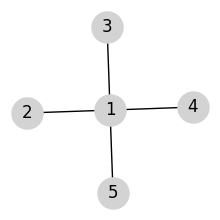

In [43]:
plt.figure(figsize=(2,2))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color="lightgray", node_size=500, with_labels=True)

In [45]:
G_prob_shortest_path = probability_shortest_path_matrix(G)
np.round(G_prob_shortest_path,2)

array([[1.  , 0.08, 0.08, 0.08, 0.08],
       [0.33, 1.  , 0.33, 0.33, 0.33],
       [0.33, 0.33, 1.  , 0.33, 0.33],
       [0.33, 0.33, 0.33, 1.  , 0.33],
       [0.33, 0.33, 0.33, 0.33, 1.  ]])

In [47]:
G_average_S = np.mean(search_information_matrix(G_prob_shortest_path))
G_average_S

1.587970000576925

Run it for all the 3 networks

In [33]:
GBA_prob_shortest_path = probability_shortest_path_matrix(GBA)
np.round(GBA_prob_shortest_path,2)

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.08],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.08],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.03],
       [0.03, 0.08, 0.03, 0.03, 0.03, 0.08, 0.03, 0.08, 0.03, 1.  ]])

In [56]:
GER_prob_shortest_path = probability_shortest_path_matrix(GER)
GER_prob_shortest_path

array([[1.00000000e+00, 4.59770115e-05, 1.56171914e-06, ...,
        4.28061831e-06, 3.81174181e-06, 2.32677184e-06],
       [5.30503979e-05, 1.00000000e+00, 6.05248328e-06, ...,
        4.50798955e-06, 3.30064693e-06, 6.83923523e-06],
       [1.41974467e-06, 4.76862319e-06, 1.00000000e+00, ...,
        2.75614203e-06, 2.79344540e-06, 3.35464974e-06],
       ...,
       [6.11516902e-06, 5.58132039e-06, 4.33108034e-06, ...,
        1.00000000e+00, 7.00280112e-05, 1.75289414e-05],
       [3.26720727e-06, 2.45190915e-06, 2.63381995e-06, ...,
        4.20168067e-05, 1.00000000e+00, 1.47427392e-06],
       [3.49015776e-06, 8.89100580e-06, 5.53517206e-06, ...,
        1.84053885e-05, 2.57997936e-06, 1.00000000e+00]])

In [57]:
GWS_prob_shortest_path = probability_shortest_path_matrix(GWS)
GWS_prob_shortest_path

array([[1.00000000e+00, 1.11111111e-03, 1.06867284e-03, ...,
        1.23456790e-03, 1.23456790e-03, 1.11111111e-03],
       [1.01010101e-03, 1.00000000e+00, 1.13636364e-03, ...,
        1.01010101e-03, 1.01010101e-03, 9.09090909e-04],
       [1.18741427e-03, 1.38888889e-03, 1.00000000e+00, ...,
        1.54320988e-03, 1.54320988e-03, 1.38888889e-03],
       ...,
       [1.23456790e-03, 1.11111111e-03, 1.38888889e-03, ...,
        1.00000000e+00, 1.23456790e-03, 1.11111111e-03],
       [1.23456790e-03, 1.11111111e-03, 1.38888889e-03, ...,
        1.23456790e-03, 1.00000000e+00, 1.11111111e-03],
       [1.01010101e-03, 9.09090909e-04, 1.13636364e-03, ...,
        1.01010101e-03, 1.01010101e-03, 1.00000000e+00]])

In [58]:
GBA_average_S = np.mean(search_information_matrix(GBA_prob_shortest_path))
GER_average_S = np.mean(search_information_matrix(GER_prob_shortest_path))
GWS_average_S = np.mean(search_information_matrix(GWS_prob_shortest_path))

In [59]:
GBA_average_S

14.784233600345518

In [60]:
GER_average_S

17.628567518048403

In [61]:
GWS_average_S

19.633736540717113

**Comparing the results:**

The bigger the **Average Search Information** the bigger the information needed to navegate in the network. It's worth mentioning that this measure grows in log2, so a small change means a lot.


**Barabasi Albert**

In this case, **Barabasi Albert** has the smaller **Seach Information**. This makes sense if you consider that this network contains **HUBS**, that is, nodes with many connections, which in this case can be interpreted as **important avenues** that have intersections with several streets, which facilitates navigation through the graph.

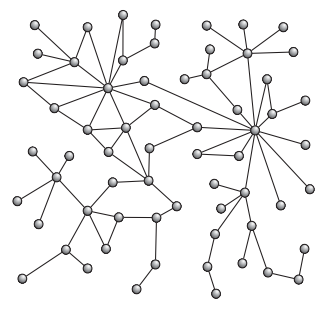

Source: Characterization of complex networks: A survey of measurements

**Erdős–Rényi**

The second smallest is the **Erdős–Rényi** network, which due to its random nature, it makes sense that the topology neither hinders nor facilitates navigation between nodes, resulting in a **Search Information** greater than that of barabasi albert, and smaller than that of small world

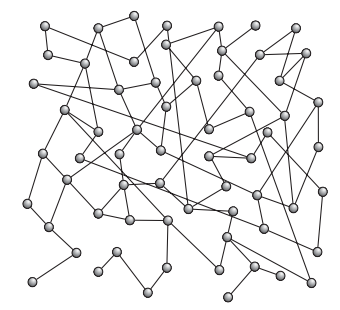

Source: Characterization of complex networks: A survey of measurements

**Watts and Strogatz**

The one with the biggest **Search Information** is **Watts and Strogatz**. It makes sense that its **Search Information** is bigger than the previously mentioned ones, because we use **p = 0.05**, and for p close to 0 the network is regular, with many triangles and large distances. Which in this case can be interpreted as neighborhoods that are very connected to each other, and there is a certain difficulty in leaving this neighborhood to reach another.

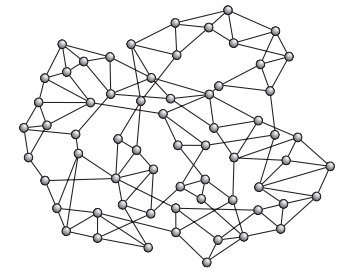

Source: Characterization of complex networks: A survey of measurements

**Small World** with **p = 0.95** to verify it´s search information:

In [62]:
GWS_p95 = nx.watts_strogatz_graph(N, k, 0.95, seed=None)

In [63]:
#get the biggest component to avoid infinity distances
GWS_p95 = get_biggest_component(GWS_p95)
GWS_p95 = nx.convert_node_labels_to_integers(GWS_p95)
len(GWS_p95)

500

In [64]:
GWS_p95_prob_shortest_path = probability_shortest_path_matrix(GWS_p95)
GWS_p95_prob_shortest_path

array([[1.00000000e+00, 5.21083854e-05, 2.75573192e-05, ...,
        1.45135215e-05, 1.40291807e-05, 4.86845973e-05],
       [4.68975469e-05, 1.00000000e+00, 8.81834215e-05, ...,
        1.20250120e-05, 2.26288765e-05, 3.49530442e-05],
       [1.65343915e-05, 5.87889477e-05, 1.00000000e+00, ...,
        2.32390749e-05, 4.81000481e-05, 1.93688587e-05],
       ...,
       [1.63277116e-05, 1.50312650e-05, 4.35732654e-05, ...,
        1.00000000e+00, 3.64394304e-05, 4.13359788e-05],
       [1.05218855e-05, 1.88573971e-05, 6.01250601e-05, ...,
        2.42929536e-05, 1.00000000e+00, 1.75364759e-05],
       [6.25944822e-05, 4.99329203e-05, 4.15046971e-05, ...,
        4.72411187e-05, 3.00625301e-05, 1.00000000e+00]])

In [65]:
GWS_p95_prob_shortest_path = np.mean(search_information_matrix(GWS_p95_prob_shortest_path))
GWS_p95_prob_shortest_path

14.665705736790093

We can see that **Search information** has **decreased** considerably, which makes sense since for p ~ 1, it becomes a random network, with small
distances and few triangles.